### Requirements (to-do-list)
CHECK --> Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

CHECK --> Apply a distortion correction to raw images.

Use color transforms, gradients, etc., to create a thresholded binary image.

Apply a perspective transform to rectify binary image ("birds-eye view").

Detect lane pixels and fit to find the lane boundary.

Determine the curvature of the lane and vehicle position with respect to center.

Warp the detected lane boundaries back onto the original image.

Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import time
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from copy import deepcopy
%matplotlib inline
#%matplotlib qt

### Utility function to print side-by-sides

In [2]:
def display_two(a,b,ta,tb):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))
    f.tight_layout()
    ax1.imshow(a,cmap='gray')
    ax1.set_title(ta, fontsize=30)
    ax2.imshow(b,cmap='gray')
    ax2.set_title(tb, fontsize=30)
def display_three(R,G,B,t1,t2,t3):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
    f.tight_layout()
    ax1.imshow(R,cmap='gray')
    ax1.set_title(t1, fontsize=30)
    ax2.imshow(G,cmap='gray')
    ax2.set_title(t2, fontsize=30)
    ax3.imshow(B,cmap='gray')
    ax3.set_title(t3, fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


### Loop through calibration images and find the chessboard corners on each image

In [3]:
images = glob.glob('./camera_cal/calibration*.jpg')
#coordinates of the board corners
objpoints = []
imgpoints = []
COLUMNS_TO_FIND = 6
objp = np.zeros((COLUMNS_TO_FIND*9,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:COLUMNS_TO_FIND].T.reshape(-1,2)

start = time.time()
for fname in images:
    
    img = mpimg.imread(fname)    
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret,corners = cv2.findChessboardCorners(gray, (9,COLUMNS_TO_FIND),None)
    
    if ret == True:    
        imgpoints.append(corners)
        objpoints.append(objp)

        #img = cv2.drawChessboardCorners(img, (9,5), corners, ret)
        
        #print("corners 0 0 ", corners[0][0])

        #print(len(corners),corners, ret)
fini = time.time()
print("It took {} seconds".format(str(fini-start)))

It took 3.1697287559509277 seconds


### Below returns distortion coef, camera matrix, rotation vec, translation vec 

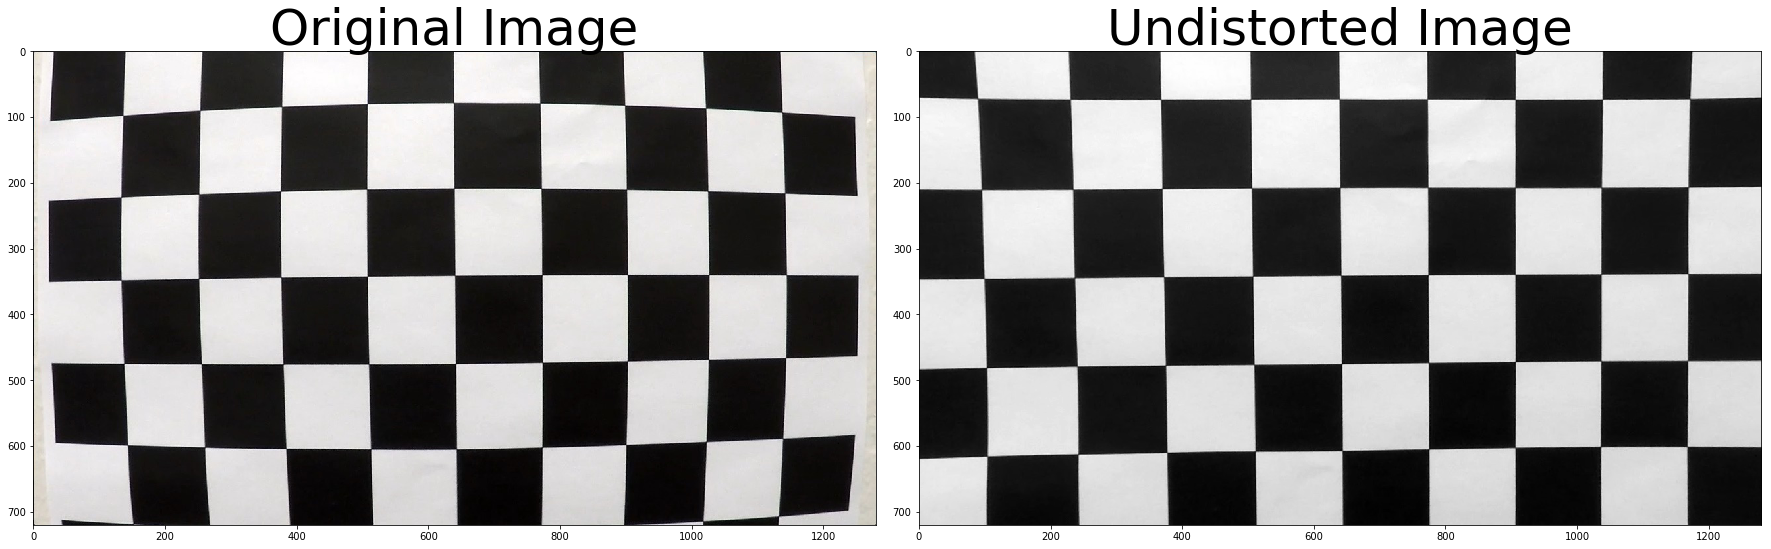

In [4]:
ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None, None)

img = mpimg.imread('./camera_cal//calibration1.jpg')
undist = np.copy(img)
gray = cv2.cvtColor(undist,cv2.COLOR_RGB2GRAY)
undistorted = cv2.undistort(gray, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted,cmap='gray')
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Undistorts the image

In [5]:
def undistort(img):
    img2 = np.copy(img)
    return cv2.undistort(img2, mtx, dist, None, mtx)

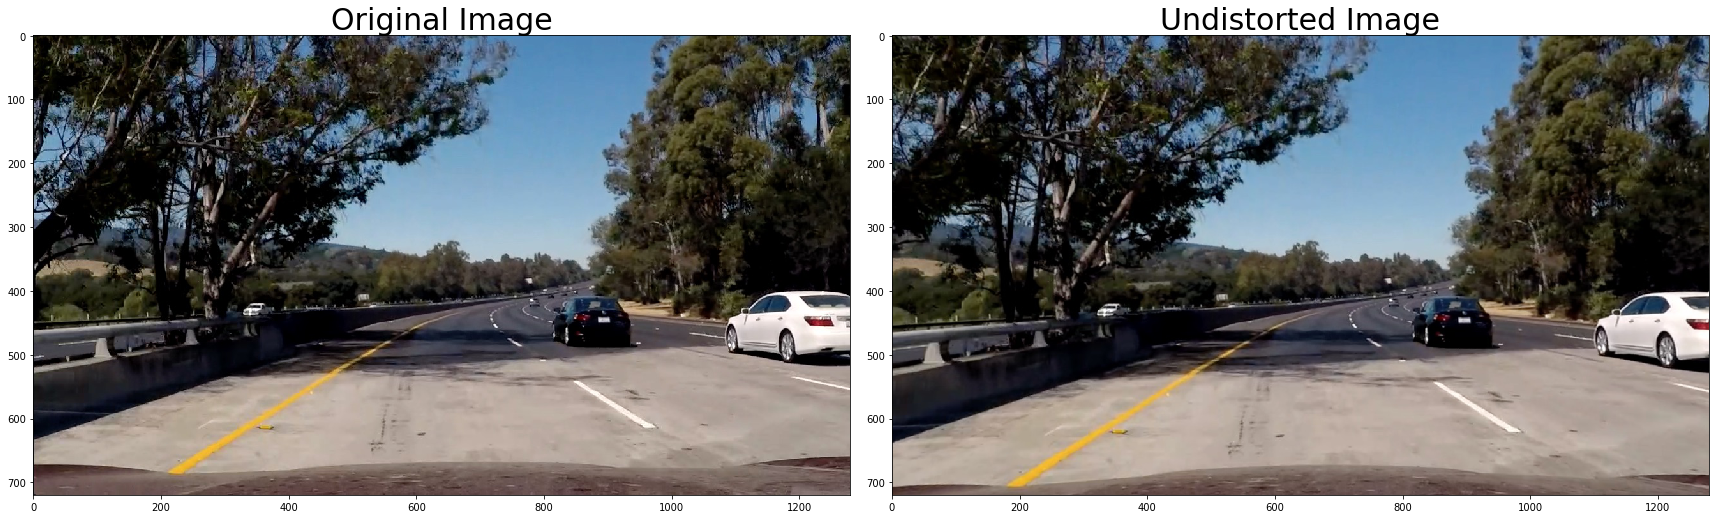

In [6]:
image_for_HLS = mpimg.imread('./test_images/test5.jpg')
undistorted = undistort(image_for_HLS)

display_two(image_for_HLS, undistorted,'Original Image','Undistorted Image')

### Functions for Pipeline to See the Lane lines only

In [7]:
def abs_sobel_thresh(img, orient='x', thresh=(0, 255) ):
    
    imgcopy = np.copy(img) 
    assert orient== 'x' or orient=='y'    
    sobel = None
    
    if orient == 'x':
        sobel = cv2.Sobel(imgcopy, cv2.CV_64F, 1, 0)
    elif orient == 'y':
        sobel = cv2.Sobel(imgcopy, cv2.CV_64F, 0, 1)
    
    abs_sobel = sobel
    
    #convert to 8-bit 0..255 image
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    #numpy zeros_like --> Returns an array of zeros with the same shape and type as a given array.
    thresh_min,thresh_max = thresh[0], thresh[1]  
    
    #new image array with zeros
    sxbinary = np.zeros_like(scaled_sobel)
    
    #make anything with the inputted thresholds 1
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return sxbinary

## Direction Threshold

In [8]:
def direction_threshold(img, sobel_kernel=15, thresh=(0, np.pi/3)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    imgcopy = np.copy(img)
    
    gray = cv2.cvtColor(imgcopy, cv2.COLOR_RGB2GRAY)    
    
    sobel = None
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    sobelx,sobely = np.absolute(sobelx), np.absolute(sobely)
    direction_of_gradient = np.arctan2( sobely, sobelx)
    
    # np.arctan2(abs_sobely, abs_sobelx) calculates the direction of the gradient 
    # Binary mask where direction thresholds are met
    # Return the mask
    
    thresh_min = thresh[0]
    thresh_max = thresh[1]    
    
    #new image array with zeros
    sxbinary = np.zeros_like(direction_of_gradient)
    
    #make anything with the inputted thresholds 1
    sxbinary[(direction_of_gradient >= thresh_min) & (direction_of_gradient <= thresh_max)] = 1
    
    return sxbinary

## Magnitude threshold

In [9]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    imgcopy = np.copy(img)
    
    gray = cv2.cvtColor(imgcopy, cv2.COLOR_RGB2GRAY)    
    
    sobel = None
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    sobelx,sobely = np.square(sobelx), np.square(sobely)
    abs_sobelxy = np.absolute(np.sqrt(sobelx + sobely) )
    
    #convert to 8-bit 0..255 image
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))

    thresh_min = mag_thresh[0]
    thresh_max = mag_thresh[1]    
    
    #new image array with zeros
    sxbinary = np.zeros_like(scaled_sobel)
    
    #make anything with the inputted thresholds 1
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return sxbinary

## Unwarp / Rewarp

In [10]:
def rewarp(img):
    
    img2 = np.copy(img)    
    
    img_size = (img.shape[1], img.shape[0])    
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])        
    M_inverse = cv2.getPerspectiveTransform(dst,src)
    
    rewarped = cv2.warpPerspective(img2, M_inverse, img_size, flags=cv2.INTER_LINEAR)
    
    return rewarped

def unwarp(img):
    '''
    After many different iterations of finding the src and dst parameters, I consulted:
    https://github.com/JustinHeaton/Advanced-Lane-Finding/blob/master/Lane_Finding.ipynb    
    '''
    img2 = deepcopy(img)
    
    img_size = (img2.shape[1], img2.shape[0])
    '''
    corners = [[[585,450]],[[150,720]],[[1170,720]],[[740,450]]]
    src = np.float32([corners[0], corners[1], corners[2], corners[3]])
    dst = np.float32([[250,0], [250,700],[960,700], [960,0]])        
    '''
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src,dst)
    
    unwarped = cv2.warpPerspective(img2, M, img_size, flags=cv2.INTER_LINEAR)
    
    return unwarped


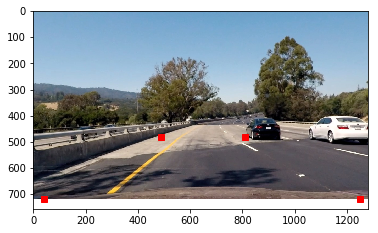

In [11]:
src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
image = undistort(mpimg.imread('./test_images/test4.jpg'))

plt.imshow(image)
for i in src:
    plt.plot(i[0],i[1],'rs')

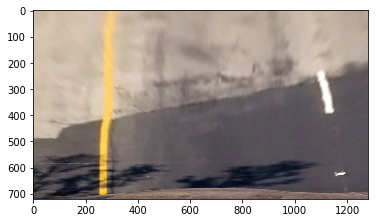

In [12]:
plt.imshow(unwarp(image))

In [13]:
def channelImageMaker(img_chann, tmin,tmax):
    '''
    takes in a single channel of an image
    output: a blue (RGB) thresholded
    '''
    
    assert len(img_chann.shape) == 2, "Check the inputted image shape; insert a channel of an image"
    
    img_channel = np.copy(img_chann)
    binary = np.zeros_like(img_channel)
    binary[(img_chann >= tmin) & (img_chann <= tmax)] = 1

    spacer = np.zeros_like(img_channel)
    binary = np.dstack((spacer,binary, spacer) ) * 255
    
    return binary

def channelToThresh(channel,tmin, tmax):
    binary = np.zeros_like(channel)
    binary[ (channel > tmin) & (channel < tmax)] = 1
    return binary

## Convert to HLS and get the S and do a thresholding on it

# A Line class to handle shitty curve fitting bullshit

from math import sqrt, isclose

class LaneWatcher:
    def __init__(self):
        
        self.image = None
        
        self.left_lane_last = None
        self.right_lane_last = None
        
        self.prev_left_polyfit = None
        self.prev_right_polyfit = None
        
        self.curr_binary_warp = None
        self.prev_binary_warp = None
        
        self.curr_curvemaker_LIST = None
        self.prev_curvemaker_LIST = None
        
        self.isFirstIteration = True
        self.numChecks = 0
        
        self.leftoutliers = 0
        self.rightoutliers = 0
        
    def next_img(self, left_polyfit, right_polyfit, binary_warped, curvemaker_list):        
        
        failed_polyfit = False        
        
        hitatolerance = False
        ############ Left polyfit ####################
        if left_polyfit.any() and right_polyfit.any() and len(left_polyfit)==3 and len(right_polyfit)==3:
            
            self.prev_left_polyfit = self.left_lane_last            
            self.left_lane_last    = left_polyfit         
        
            self.prev_right_polyfit = self.right_lane_last
            self.right_lane_last    = right_polyfit
            
            self.curr_binary_warp = binary_warped
            self.prev_binary_warp = binary_warped
            
            self.curr_curvemaker_LIST = curvemaker_list
            self.prev_curvemaker_LIST = curvemaker_list
            
            if self.isFirstIteration:
                self.isFirstIteration = False
                left = [self.left_lane_last[0] ]
                right = [self.right_lane_last[0] ]
            else:
                left = [self.left_lane_last[0],self.prev_left_polyfit[0]]
                right = [self.right_lane_last[0], self.prev_right_polyfit[0]]
            
                self.leftoutliers += 1
                self.rightoutliers += 1
                if isclose(left[0], left[1]):
                    hitatolerance = True
                    failed_polyfit = True
                    #self.leftoutliers += 1
                if isclose(right[0] , right[1]):
                    hitatolerance = True
                    failed_polyfit = True
                    #self.rightoutliers += 1
                
        else:
            failed_polyfit = True
                                   
            self.left_lane_last = self.prev_left_polyfit
            self.curr_binary_warp = self.prev_binary_warp
            
            self.right_lane_last = self.prev_right_polyfit
            
            self.curr_binary_warp = self.prev_binary_warp
            
            self.curr_curvemaker_LIST = self.prev_curvemaker_LIST
                
        if failed_polyfit:           
            
            return self.left_lane_last, self.right_lane_last, self.curr_binary_warp, self.curr_curvemaker_LIST
        else:
            self.numChecks += 1
            with open("alog.log",'w') as ofo:
                ofo.write("left --> " + str(self.leftoutliers) + 
                        " right --> "+ str(self.rightoutliers) )
            
            return left_polyfit, right_polyfit, self.curr_binary_warp, self.curr_curvemaker_LIST     

In [289]:
from math import sqrt, isclose
from collections import deque

class LaneWatcher:
    def __init__(self):
        
        self.image = None
        
        self.curr_binary_warp = None
        self.prev_binary_warp = None
        
        self.curr_curvemaker_LIST = None
        self.prev_curvemaker_LIST = None
        
        self.isFirstIteration = True
        self.numChecks = 0
        
        self.last_good_fit = []
        
        self.theyequal = 0
        
        self.last5left  = deque()
        self.last5right = deque()
        
        self.avgLeft = 0
        self.avgRight = 0
        
        self.leftprev  = None
        self.rightprev = None
        
    def track_good_fit(self,left_polyfit,right_polyfit):
        #out with the old, in with the new
        if len(self.last5left) == 5:
            self.last5left.pop()
        if len(self.last5left) < 5:
            self.last5left.appendleft(left_polyfit)
        #out with the old, in with the new
        if len(self.last5right) == 5:
            self.last5right.pop()
        if len(self.last5right) < 5:
            self.last5right.appendleft(right_polyfit)
        
        if len(self.last5left)==0 or len(self.last5right)==0:
            nonsensevariablejokeish=9
        else:
            l = [i[0] for i in self.last5left]
            r = [i[0] for i in self.last5right]

            self.avgRight = self.last5left[0]
            self.avgLeft  = self.last5right[0]

            for i in range(1,len(self.last5right)):            
                self.avgRight += self.last5right[i]
                self.avgLeft  += self.last5left[i]
            
        
    def next_img(self, left_polyfit, right_polyfit, binary_warped, curvemaker_list):      
        
        self.track_good_fit(left_polyfit, right_polyfit)
        
        failed_polyfit = False
        
        ############ Left polyfit ####################
        # if its found
        if left_polyfit.any() and right_polyfit.any() and len(left_polyfit)==3 and len(right_polyfit)==3:
            
            #### --> Sanity Check eg is the curve cool? <-- #####
            if self.isFirstIteration:
                self.isFirstIteration = False
                self.leftprev  = left_polyfit
                self.rightprev = right_polyfit
            else:
                bag = False
                if abs(left_polyfit[0]-self.leftprev[0]) > 3.1261240199999998e-05:
                    bag = True
                    failed_polyfit = True
                if abs(right_polyfit[0]-self.rightprev[0]) > 3.0084269799999995e-05:
                    bag = True
                    failed_polyfit = True
                    
                if not bag:
                    leftR = (self.leftprev * .9)   + (left_polyfit * .1)
                    rightR = (self.rightprev * .9) + (right_polyfit * .1)
                    return leftR, rightR, self.curr_binary_warp, self.curr_curvemaker_LIST
                else:
                    leftR = (self.avgLeft * .9)   + (self.leftprev * .1)
                    rightR = (self.avgRight * .9) + (self.rightprev * .1)
                    return leftR, rightR, self.curr_binary_warp, self.curr_curvemaker_LIST
            ######## --> end of sanity check <------ ###### 
            
            
            self.curr_binary_warp = binary_warped
            self.prev_binary_warp = binary_warped
            
            self.curr_curvemaker_LIST = curvemaker_list
            self.prev_curvemaker_LIST = curvemaker_list
        
        #this means polyfit failed somewhere
        else:
            
            failed_polyfit = True                        
            self.curr_binary_warp = self.prev_binary_warp
            self.curr_curvemaker_LIST = self.prev_curvemaker_LIST
                
        if failed_polyfit:        

            return self.leftprev, self.rightprev, self.curr_binary_warp, self.curr_curvemaker_LIST
        else:            
            return left_polyfit, right_polyfit, self.curr_binary_warp, self.curr_curvemaker_LIST     

In [290]:
def filtered_image_to_curve(binary_warped, undistorted):
    
    img_start = np.copy(undistorted)
    
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    try:
        left_fit = np.polyfit(lefty, leftx, 2)
    except TypeError:
        left_fit = np.array([])
        
    try:
        right_fit = np.polyfit(righty, rightx, 2)
    except TypeError:
        right_fit = np.array([])
    
    result = None
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    curvemaker_list = [ploty, out_img, nonzerox, nonzeroy, left_lane_inds, right_lane_inds]
    
    if not left_fit.any() or not right_fit.any():
        return img_start, left_fit, right_fit, curvemaker_list
    
    return img_start, left_fit, right_fit, curvemaker_list
  
def fitted_curve_to_mask_on_screen(img_start, left_fit, right_fit, curvemaker):
    
    ploty, out_img, nonzerox, nonzeroy, left_lane_inds, right_lane_inds = curvemaker
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    window_img = np.zeros_like(out_img)
    
    left_line_window = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line_window = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    
    pts = np.hstack((left_line_window, right_line_window))

    cv2.fillPoly(window_img, np.int_([pts]), (0,255, 255))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)    
    newwarp = rewarp(window_img)    
    result = cv2.addWeighted(img_start, 1, newwarp, 0.5, 0)
    
    return result

In [291]:
def get_lane_lines(image_for_line_extraction):
    
    rgb = np.copy(image_for_line_extraction)    
    img = np.copy(image_for_line_extraction)
    
    hls = cv2.cvtColor(np.copy(image_for_line_extraction), cv2.COLOR_RGB2HLS)        
    H_hls = hls[:,:,0]
    H_hls = channelToThresh(H_hls,20,60)
    
    #Saturation channel of HLS
    s_channel = hls[:,:,2]
    s_thresh_min = 185
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    #scaled sobel
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))    
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    combined_binary = np.zeros_like(sxbinary)
    
    R_rgb = rgb[:,:,0]    
    B_rgb = rgb[:,:,2]
    
    hsv = cv2.cvtColor(np.copy(image_for_line_extraction), cv2.COLOR_RGB2HSV)
    V_hsv = hsv[:,:,2]
    V_hsv = channelToThresh(V_hsv,0,230 )
    V_hsv = cv2.bitwise_not(V_hsv)
    
    B_rgb = channelToThresh(B_rgb, 190, 250)     

    R_rgb = channelToThresh(R_rgb, 0, 230)
    R_rgb = cv2.bitwise_not(R_rgb)    
    
    H_hls = cv2.blur(H_hls,(5,5))
    B_rgb = cv2.blur(B_rgb,(5,5))
    
    combined_binary[(V_hsv==1)|(s_binary == 1) | (H_hls == 1) | (B_rgb == 1) | (R_rgb==1)] = 1
    return unwarp(combined_binary)

def gaussian_blur(img, kernel=5):
    blurred_img = cv2.GaussianBlur(img, ( kernel, kernel ), 0)
    return blurred_img

lane_watch = LaneWatcher()

def pipeline23(input_image):
    undistorted = undistort(np.copy(input_image))
    
    binary_warped = get_lane_lines(undistorted)
    
    img_start, left_fit, right_fit, curvemaker_list = filtered_image_to_curve(binary_warped,undistorted)    
    
    #outputs the most recent fitted curves that successfully worked
    left_fit, right_fit, binary_warped, curvemaker_list = lane_watch.next_img(left_fit, right_fit, binary_warped, curvemaker_list)
    
    # makes a curve that fits on the original image
    # this may come from the previous fit curve
    img_start, left_fit, right_fit, curvemaker_list = filtered_image_to_curve(binary_warped,undistorted) 
    
    out_img = fitted_curve_to_mask_on_screen(img_start, left_fit, right_fit, curvemaker_list)
    
    return out_img#binary_warped

#binary_warped = pipeline23(mpimg.imread('./test_images/test4.jpg'))
#plt.imshow(binary_warped,cmap='gray' ) 
#plt.plot(binary_warped[1],binary_warped[3],'yellow')
#plt.plot(binary_warped[2],binary_warped[3],'yellow')

In [292]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'white.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip2 = clip1.subclip(39,42)
white_clip = clip2.fl_image(pipeline23)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4















  0%|          | 0/76 [00:00<?, ?it/s]












  1%|▏         | 1/76 [00:00<00:13,  5.39it/s]












  3%|▎         | 2/76 [00:00<00:13,  5.35it/s]












  4%|▍         | 3/76 [00:00<00:13,  5.33it/s]












  5%|▌         | 4/76 [00:00<00:13,  5.29it/s]












  7%|▋         | 5/76 [00:00<00:13,  5.09it/s]












  8%|▊         | 6/76 [00:01<00:13,  5.23it/s]












  9%|▉         | 7/76 [00:01<00:12,  5.49it/s]












 11%|█         | 8/76 [00:01<00:12,  5.65it/s]












 12%|█▏        | 9/76 [00:01<00:11,  5.77it/s]












 13%|█▎        | 10/76 [00:01<00:11,  5.89it/s]












 14%|█▍        | 11/76 [00:01<00:11,  5.90it/s]












 16%|█▌        | 12/76 [00:02<00:10,  5.94it/s]












 17%|█▋        | 13/76 [00:02<00:10,  5.93it/s]












 18%|█▊        | 14/76 [00:02<00:10,  6.02it/s]












 20%|█▉        | 15/76 [00:02<00:09,  6.11it/s]












 21%|██        | 16/76 [00:02<00:09,  6.08it/

[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 1min 4s, sys: 15.4 s, total: 1min 20s
Wall time: 16.1 s


### Get a bird eye view of the lane, Perspective transform FIND THE POINTS, ORDER THEM ALL !!!!!

In [89]:
def printLotsOfThresholds(images, number_of_columns,FIGSIZE = (12,12)):
    
    fig = plt.figure(figsize=FIGSIZE)
    col = 0    
    
    for i,t in enumerate(images):
        
        col += 1
        
        if col == number_of_columns + 1:
            fig = plt.figure(figsize=FIGSIZE)
            col = 1
        
        binary_warped = t
        
        fig.add_subplot(1,number_of_columns,col)     
        
        plt.imshow(binary_warped ,cmap='gray') 
        #plt.plot( binary_warped[1],binary_warped[3],'y',linewidth=2)
        #plt.plot( binary_warped[2],binary_warped[3],'y',linewidth=2)
        plt.axis('off')
        title = "Image -:{0}, {1} \n".format(
        str(i), str(i) )        
        plt.title(title, wrap=True)

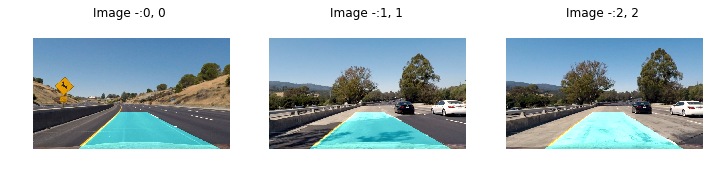

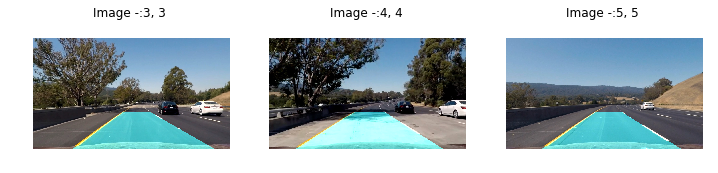

In [90]:
test_images = glob.glob('./test_images/test*.jpg')

test_img = []
for fname in test_images:
    test_img.append(pipeline23(mpimg.imread(fname)))
                    
printLotsOfThresholds(test_img, 3)

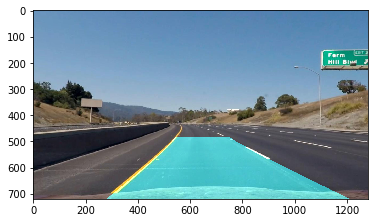

In [44]:
input_image = mpimg.imread('./test_images/frame_at_41.jpg')

a_problem = pipeline23(input_image) 
plt.imshow(a_problem)
#plt.imshow(pipeline(input_image) )

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4





  0%|          | 0/101 [00:00<?, ?it/s]


  1%|          | 1/101 [00:00<00:16,  6.07it/s]


  2%|▏         | 2/101 [00:00<00:15,  6.24it/s]


  3%|▎         | 3/101 [00:00<00:15,  6.16it/s]


  4%|▍         | 4/101 [00:00<00:15,  6.41it/s]


  5%|▍         | 5/101 [00:00<00:15,  6.15it/s]


  6%|▌         | 6/101 [00:00<00:15,  6.25it/s]


  7%|▋         | 7/101 [00:01<00:14,  6.43it/s]


  8%|▊         | 8/101 [00:01<00:13,  6.68it/s]


  9%|▉         | 9/101 [00:01<00:14,  6.42it/s]


 10%|▉         | 10/101 [00:01<00:14,  6.43it/s]


 11%|█         | 11/101 [00:01<00:13,  6.46it/s]


 12%|█▏        | 12/101 [00:01<00:13,  6.41it/s]


 13%|█▎        | 13/101 [00:02<00:13,  6.45it/s]


 14%|█▍        | 14/101 [00:02<00:13,  6.46it/s]


 15%|█▍        | 15/101 [00:02<00:13,  6.39it/s]


 16%|█▌        | 16/101 [00:02<00:13,  6.41it/s]


 17%|█▋        | 17/101 [00:02<00:12,  6.48it/s]


 18%|█▊        | 18/101 [00:02<00:12,  6.45it/s]


 19%|█▉        | 19/101 [00:02<00:12,  6.40it/

[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 1min 19s, sys: 18.7 s, total: 1min 38s
Wall time: 19.9 s


In [50]:
import moviepy.editor as mpe
video = mpe.VideoFileClip('project_video.mp4')

fps = 25
np_frame = video.get_frame(t=41) # get the frame at t=2 seconds
#np_frame = video.get_frame(frame_number * video_fps) # get frame by index
video.save_frame('./test_images/frame_at_41.jpg', t=2)

In [20]:
white_output = 'challenge_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

NameError: name 'pipeline' is not defined